In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Audio
import librosa.feature as ft
import wave
import struct
import librosa
import time
import librosa.display
from os import listdir
from os.path import isfile, join
import scipy.io
from mpl_toolkits import mplot3d
import pickle
%matplotlib widget

In [2]:
def remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 1000) :
    """
    Renvoie le signal tronqué avec le vecteurs temps associé

    # Inputs
    - sig : signal audio à tronquer
    - fs : fréquence d'échantillonnage (utile pour regénérer le vecteur temps)
    - ratio_parameter : paramètre à adapter pour couper plus ou moins le bruit. 6 par défaut

    # Ouputs
    - time : nouveau vecteur temps
    - sig : nouveau signal audio tronqué
    """
    sig /= np.max(np.abs(sig))
    noise = sig[:len_noise]
    if method == "mean" :
        noise_threshold = np.mean(np.abs(noise))
    elif method == "max" :
        noise_threshold = np.max(np.abs(noise))

    i=0
    while np.abs(sig[i]) < ratio_parameter*noise_threshold :
        i += 1
    #i correspond au premier indice au dessus du seuil
    sig = sig[i:]
    time = np.arange(len(sig))/fs
    return time, sig


In [3]:
def spectral_slope(data, sr, n_fft=2048, hop_length=None, win_length=None, 
                   window='hann', center=True, pad_mode='constant'):

    S, phase = librosa.magphase(librosa.stft(y=data, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                             center=center, pad_mode=pad_mode))
    slope = np.zeros((1,S.shape[1]))
    freq = librosa.fft_frequencies(sr=sr, n_fft=n_fft)
    for k in range(S.shape[1]):
        fit = np.polyfit(freq, S[:,k], 1)
        slope[0,k] =fit[0]
    return slope


def compute_features(data, sr, S=None, n_fft=4096, frame_length=2048, hop_length=512, win_length=None, window='hann',
                     center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                     p=2, amin=1e-10, power=2.0,roll_percent=0.85):
    
    
    cent = librosa.feature.spectral_centroid(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, freq = freq,
                                             win_length=win_length, window=window, center=center, pad_mode=pad_mode)
    spec_bw = librosa.feature.spectral_bandwidth(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                 center=center, pad_mode=pad_mode, freq=freq, centroid=centroid, norm=norm, p=p)
    contrast = librosa.feature.spectral_contrast(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, freq=freq, fmin=fmin, n_bands=n_bands, quantile=quantile, linear=linear)
    
    flatness = librosa.feature.spectral_flatness(y=data, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, center=center,
                                                 pad_mode=pad_mode, amin=amin, power=power)
    
    rolloff = librosa.feature.spectral_rolloff(y=data, sr=sr, S=S, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=window, 
                                                center=center, pad_mode=pad_mode, freq=freq, roll_percent=roll_percent)
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length, center=center)
    
    rms = librosa.feature.rms(y=data, S=S, frame_length=frame_length, hop_length=hop_length, center=center, pad_mode=pad_mode)
    
    slope = spectral_slope(data, sr, n_fft=n_fft, hop_length=hop_length, win_length=win_length, 
                   window=window, center=center, pad_mode=pad_mode)
    
    dict_features = {}
    dict_features['spectral_centroid'] = cent
    dict_features['spectral_bandwidth'] = spec_bw
    dict_features['spectral_contrast'] = contrast
    dict_features['spectral_flatness'] = flatness
    dict_features['spectral_rolloff'] = rolloff
    dict_features['zero_crossing_rate'] = zcr
    dict_features['rms'] = rms
    dict_features['spectral_slope'] = slope
    
    return dict_features

In [4]:
def recup_data(monRepertoire):
    fichiers = [f for f in listdir(monRepertoire) if (isfile(join(monRepertoire, f)) and 'parametres' not in f)]
    data={}
    k=0

    for fichier in fichiers:
        data_seul,_ = librosa.load(monRepertoire+fichier,sr=Fe)
        data[str(k)] = data_seul
        k+=1
    all_cle = list(data.keys())
                
    return all_cle,data

In [5]:
def recup_data_vico(monRepertoire):
    corde_dos = [f for f in listdir(monRepertoire) if 'DS' not in f]
    data={}
    k=0
    for corde in corde_dos:
        fichiers = [f for f in listdir(monRepertoire+corde) if 'parametres' not in f and 'DS' not in f and 'detail' not in f]
        for fichier in fichiers:
            data_seul,_ = librosa.load(monRepertoire+corde+'/'+fichier,sr=Fe)
            if np.mean(data_seul) !=0 :
                data[str(k)] = data_seul
                k+=1
            else:
                print(monRepertoire+corde+'/'+fichier+' est nulle')
    all_cle = list(data.keys())
                
    return all_cle,data

In [6]:
def ordoner_data(data,all_cle):
    M = np.zeros((len(data[all_cle[0]]), len(data.keys())))
    i=0
    for cle in all_cle:
        M[:,i] = data[cle]
        i+=1
    return M

In [7]:
def creer_features(data,all_cle,M, Fe):
    data_features={}
    for k in range(len(all_cle)):
        data_features[all_cle[k]] = compute_features(M[:,k], sr=Fe, S=None, n_fft=4096, hop_length=256, win_length=None, window='hann',
                         center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=3, quantile=0.02, linear=False, centroid=None, norm=True,
                         p=2, amin=1e-10, power=2.0,roll_percent=0.85)
    return data_features

In [8]:
def recup_features(repertoire_features):
    with open(repertoire_features, "rb") as handle:
        dict_class = pickle.load(handle)
    return dict_class

In [9]:
features_already_calculate = True #Si les features sont dejà calculé pour ce dataset, mettre la valeur True
enregistrer_features = False #Si les features ne sont pas calculé pour ce dataset et qu'on veut enregistrer, mettre la valeur True
repertoire_features = "../../Mesures/test_vico8/audio_features.pickle" #repertoire pour enregistrer et load les featrues


Fe = 2**14 #Faire très attention, Fe peut changer en fonction du dataset qu'on load
repertoire_1 = '../../Mesures/test_vico8/metal/'
repertoire_2 = '../../Mesures/test_vico8/medium_1/'
repertoire_3 = '../../Mesures/test_vico8/medium_2/'
repertoire_4 = '../../Mesures/test_vico8/plexi/'

liste_repertoire = [repertoire_1,repertoire_2,repertoire_3,repertoire_4]



if features_already_calculate == False:
    dict_class={}
    
    for repertoire in liste_repertoire:
        dict_class[repertoire]={}
        all_cle,data = recup_data_vico(repertoire)
        M=ordoner_data(data,all_cle)
        data_features = creer_features(data,all_cle,M, Fe)
        
        M_spec_bw = np.zeros((len(data_features[all_cle[0]]['spectral_bandwidth'][0]),len(all_cle)))
        M_cent = np.zeros((len(data_features[all_cle[0]]['spectral_centroid'][0]),len(all_cle)))
        M_contrast = np.zeros((len(data_features[all_cle[0]]['spectral_contrast'][0]),len(all_cle)))
        M_flatness = np.zeros((len(data_features[all_cle[0]]['spectral_flatness'][0]),len(all_cle)))
        M_slope = np.zeros((len(data_features[all_cle[0]]['spectral_slope'][0]),len(all_cle)))
        M_rolloff= np.zeros((len(data_features[all_cle[0]]['spectral_rolloff'][0]),len(all_cle)))
        i=0
        for cle in all_cle:
            M_spec_bw[:,i] = data_features[cle]['spectral_bandwidth'][0]
            M_cent[:,i] = data_features[cle]['spectral_centroid'][0]
            M_contrast[:,i] = data_features[cle]['spectral_contrast'][0]
            M_flatness[:,i] = data_features[cle]['spectral_flatness'][0]
            M_slope[:,i] = data_features[cle]['spectral_slope'][0]
            M_rolloff[:,i] = data_features[cle]['spectral_rolloff'][0]
            i+=1
        
        dict_class[repertoire]['spectral_bandwidth'] = M_spec_bw
        dict_class[repertoire]['spectral_centroid'] = M_cent
        dict_class[repertoire]['spectral_contrast'] = M_contrast
        dict_class[repertoire]['spectral_flatness'] = M_flatness
        dict_class[repertoire]['spectral_slope'] = M_slope
        dict_class[repertoire]['spectral_rolloff'] = M_rolloff
    
    if enregistrer_features:
        with open(repertoire_features, 'wb') as f:
            pickle.dump(dict_class, f)
    
    
else:
    dict_class = recup_features(repertoire_features)

In [10]:
repertoire_features_exp = '../../Mesures/Mesures_2023.01.27_LAM_normalise/audio_features_exp.pickle'
features_already_calculate_exp = True
enregister_features_exp = False
monRepertoire_experience = '../../Mesures/Mesures_2023.01.27_LAM_normalise/'


if features_already_calculate_exp == False:

    fichiers_table = [f for f in listdir(monRepertoire_experience) if not isfile(join(monRepertoire_experience, f))]
    data_experience = {}
    for matiere in fichiers_table:
        fichiers_corde = [f for f in listdir(monRepertoire_experience+matiere) if not isfile(join(monRepertoire_experience+matiere, f))]
        for corde in fichiers_corde:
            fichiers_mat = [f for f in listdir(monRepertoire_experience+matiere+'/'+corde) if (isfile(join(monRepertoire_experience+matiere+'/'+corde, f) ))]
            for mat in fichiers_mat:
                if mat != ".DS_Store":
                    sig = scipy.io.loadmat(monRepertoire_experience+matiere+'/'+corde+'/'+mat)['acc_t']
                    fs = scipy.io.loadmat(monRepertoire_experience+matiere+'/'+corde+'/'+mat)['fs'][0][0]
                    time, wav = remove_init_noise(sig, fs, method="mean", ratio_parameter = 6, len_noise = 10000)
                    
                    wav = wav[:int(fs*3)] #3 parce que les samples synthétiques font 3 secondes
                    data_experience[matiere+'_'+corde+'_'+mat] = {}
                    data_experience[matiere+'_'+corde+'_'+mat]['data'] = wav
                    data_experience[matiere+'_'+corde+'_'+mat]['table_matiere'] = matiere
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_matiere'] = corde
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_plectre'] = mat
                    data_experience[matiere+'_'+corde+'_'+mat]['Fe'] = fs

                    if matiere == 'Metal':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 2700
                    if matiere == 'Plexi':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 1180
                    if matiere == 'Medium_1':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 600
                    if matiere == 'Medium_2':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 800

                    if 'C_1' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 1
                    if 'C_2' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 2
                    if 'C_3' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 3
                    if 'C_4' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 4
                    if 'C_5' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 5
                    if 'C_6' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 6

                    if 'P_1' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 1
                    if 'P_2' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 2
                    if 'P_3' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 3
                    if 'P_4' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 4
                        
    all_cle_exp = list(data_experience.keys())
    x_exp = data_experience[all_cle_exp[0]]['data']
    Fe_exp = data_experience[all_cle_exp[0]]['Fe']

    M_exp = np.zeros((len(x_exp), len(data_experience.keys())))
    i=0
    for cle in all_cle_exp:
        M_exp[:,i] = np.reshape(data_experience[cle]['data'],(len(x_exp)))
        i+=1
        
    data_features_exp={}
    for k in range(len(data_experience.keys())):
        data_features_exp[all_cle_exp[k]] = compute_features(M_exp[:,k], sr=Fe_exp, S=None, n_fft=4096, hop_length=256, win_length=None, window='hann',
                         center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                         p=2, amin=1e-10, power=2.0,roll_percent=0.85)
    if enregister_features_exp:
        with open(repertoire_features_exp, 'wb') as f:
            pickle.dump(data_features_exp, f)
    

else:
    data_features_exp = recup_features(repertoire_features_exp)
    all_cle_exp = list(data_features_exp.keys())

In [11]:
repertoire_features_exp = '../../Mesures/Mesures_2023.01.27_LAM_normalise_hr/harmo/audio_features_exp.pickle'
features_already_calculate_exp = True
enregister_features_exp = False
monRepertoire_experience = '../../Mesures/Mesures_2023.01.27_LAM_normalise_hr/harmo/'
Fe_exp = 22050

if features_already_calculate_exp == False:

    fichiers_table = [f for f in listdir(monRepertoire_experience) if not isfile(join(monRepertoire_experience, f))]
    data_experience = {}
    for matiere in fichiers_table:
        fichiers_corde = [f for f in listdir(monRepertoire_experience+matiere) if not isfile(join(monRepertoire_experience+matiere, f))]
        for corde in fichiers_corde:
            fichiers_mat = [f for f in listdir(monRepertoire_experience+matiere+'/'+corde) if (isfile(join(monRepertoire_experience+matiere+'/'+corde, f) ))]
            for mat in fichiers_mat:
                if mat != ".DS_Store":
                    fs=Fe_exp
                    sig,_ = librosa.load(monRepertoire_experience+matiere+'/'+corde+'/'+mat,sr=Fe_exp)
                    
                    time, wav = remove_init_noise(sig, fs, method="mean", ratio_parameter = 4, len_noise = 10000)
                    wav = wav[:int(fs*3)] #3 parce que les samples synthétiques font 3 secondes
                    data_experience[matiere+'_'+corde+'_'+mat] = {}
                    data_experience[matiere+'_'+corde+'_'+mat]['data'] = wav
                    data_experience[matiere+'_'+corde+'_'+mat]['table_matiere'] = matiere
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_matiere'] = corde
                    data_experience[matiere+'_'+corde+'_'+mat]['corde_plectre'] = mat
                    data_experience[matiere+'_'+corde+'_'+mat]['Fe'] = fs

                    if matiere == 'Metal':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 2700
                    if matiere == 'Plexi':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 1180
                    if matiere == 'Medium_1':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 600
                    if matiere == 'Medium_2':
                        data_experience[matiere+'_'+corde+'_'+mat]['rho_table'] = 800

                    if 'C_1' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 1
                    if 'C_2' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 2
                    if 'C_3' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 3
                    if 'C_4' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 4
                    if 'C_5' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 5
                    if 'C_6' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['corde_numero'] = 6

                    if 'P_1' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 1
                    if 'P_2' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 2
                    if 'P_3' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 3
                    if 'P_4' in mat:
                        data_experience[matiere+'_'+corde+'_'+mat]['plectre_numero'] = 4
                        
    all_cle_exp = list(data_experience.keys())
    x_exp = data_experience[all_cle_exp[0]]['data']
    Fe_exp = data_experience[all_cle_exp[0]]['Fe']

    M_exp = np.zeros((len(x_exp), len(data_experience.keys())))
    i=0
    for cle in all_cle_exp:
        M_exp[:,i] = np.reshape(data_experience[cle]['data'],(len(x_exp)))
        i+=1
        
    data_features_exp={}
    for k in range(len(data_experience.keys())):
        data_features_exp[all_cle_exp[k]] = compute_features(M_exp[:,k], sr=Fe_exp, S=None, n_fft=2048, hop_length=256, win_length=None, window='hann',
                         center=True, pad_mode='constant', freq=None, fmin=200.0, n_bands=6, quantile=0.02, linear=False, centroid=None, norm=True,
                         p=2, amin=1e-10, power=2.0,roll_percent=0.85)
    if enregister_features_exp:
        with open(repertoire_features_exp, 'wb') as f:
            pickle.dump(data_features_exp, f)
    

else:
    data_features_exp_hr = recup_features(repertoire_features_exp)
    all_cle_exp_hr = list(data_features_exp.keys())

In [12]:
debut=0
fin=-8

debut_exp=0
fin_exp = -8
t_synt = np.linspace(0,3,193)
t_exp = np.linspace(0,3,601)
t_exp_hr = np.linspace(0,3,259)

In [17]:
plt.rc('text', usetex=True)
plt.rc('font', size = 10)
plt.rc('font', family='serif')

In [18]:
fig,ax = plt.subplots(2,1, figsize=(9/1.5,7/1.5))
fig.set_size_inches(w=3.48715013889, h=2.2)
fig.tight_layout()
#fig.suptitle("Comparaison de l'évolution de différents descripteurs\n entre les données synthéthiques et expérimentales pour la table Aluminium")
numero = 5
exp_num = 'Metal_Corde_Acier_C_1_P_4.mat'
exp_num_hr = 'Metal_Corde_Acier_C_1_P_4.wav'
synt = dict_class['../../Mesures/test_vico8/metal/']['spectral_centroid'][:,numero][debut:fin]
exp = data_features_exp[exp_num]['spectral_centroid'][0,:][debut_exp:fin_exp]
exp_hr = data_features_exp_hr[exp_num_hr]['spectral_centroid'][0,:][debut_exp:fin_exp]
ax[0].plot(t_synt[debut:fin],synt, label = 'Synthèse')
ax[0].plot(t_exp[debut_exp:fin_exp],exp, label = "Expérience")
#ax[0].plot(t_exp_hr[debut_exp:fin_exp],exp_hr, label = "Partie harmonique expérience")
ax[0].set_ylabel('Centroïde spectral', fontsize = 10)
#ax[0,0].set_title('Centroïde spectral')
'''
ax[1,0].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_slope'][:,numero][debut:fin], label = 'Synthèse')
ax[1,0].plot(t_exp[debut_exp:fin_exp],data_features_exp[exp_num]['spectral_slope'][0,:][debut_exp:fin_exp], label = "Expérience")
ax[1,0].set_xlabel('Temps (s)')
ax[1,0].set_ylabel('Pente spectrale')
#ax[1,0].set_title('Pente spectrale')
'''
ax[1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Synthèse')
ax[1].plot(t_exp[debut_exp:fin_exp],data_features_exp[exp_num]['spectral_bandwidth'][0,:][debut_exp:fin_exp], label = "Expérience")
#ax[1].plot(t_exp_hr[debut_exp:fin_exp],data_features_exp_hr[exp_num_hr]['spectral_bandwidth'][0,:][debut_exp:fin_exp], label = "Partie harmonique expérience")
ax[1].set_xlabel('Temps (s)', fontsize = 10)
ax[1].set_ylabel('Bande spectrale', fontsize = 10)
#ax[0,1].set_title('Bande spectrale')
'''
ax[1,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_contrast'][:,numero][debut:fin], label = 'Synthèse')
ax[1,1].plot(t_exp[debut_exp:fin_exp],data_features_exp[exp_num]['spectral_contrast'][0,:][debut_exp:fin_exp], label = "Expérience")
ax[1,1].set_xlabel('Temps (s)')
ax[1,1].set_ylabel('Contraste spectral')
'''
ax[0].legend()
ax[1].legend()



'''
ax[1,0].legend()
ax[1,1].legend()
'''
#plt.savefig('C:/Users/Ulysse/Desktop/ATIAM/PAM/descripteurs_aluminium_hr_and_normal.pdf')

RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous view', 'arrow-left', 'back'), ('Forward', 'Forward to next view', 'arrow-right', 'forward'), ('Pan', 'Left button pans, Right button zooms\nx/y fixes axis, CTRL fixes aspect', 'arrows', 'pan'), ('Zoom', 'Zoom to rectangle\nx/y fixes axis', 'square-o', 'zoom'), ('Download', 'Download plot', 'floppy-o', 'save_figure')]))

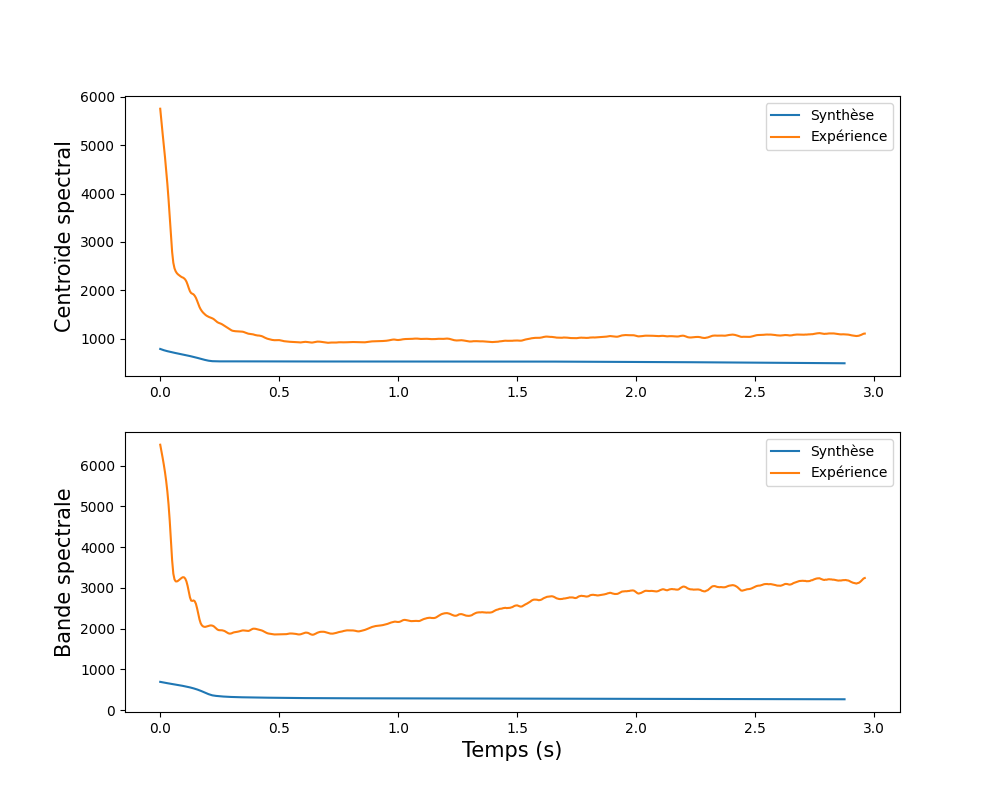

In [19]:
fig,ax = plt.subplots(2,1, figsize=(10,8))
#fig.suptitle("Comparaison de l'évolution de différents descripteurs\n entre les données synthéthiques et expérimentales pour la table Aluminium")
numero = 5
exp_num = 'Metal_Corde_Acier_C_1_P_4.mat'
synt = dict_class['../../Mesures/test_vico8/metal/']['spectral_centroid'][:,numero][debut:fin]
exp = data_features_exp[exp_num]['spectral_centroid'][0,:][debut_exp:fin_exp]
ax[0].plot(t_synt[debut:fin],synt, label = 'Synthèse')
ax[0].plot(t_exp[debut_exp:fin_exp],exp, label = "Expérience")
ax[0].set_ylabel('Centroïde spectral', fontsize=15)
#ax[0,0].set_title('Centroïde spectral')
'''
ax[1,0].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_slope'][:,numero][debut:fin], label = 'Synthèse')
ax[1,0].plot(t_exp[debut_exp:fin_exp],data_features_exp[exp_num]['spectral_slope'][0,:][debut_exp:fin_exp], label = "Expérience")
ax[1,0].set_xlabel('Temps (s)')
ax[1,0].set_ylabel('Pente spectrale')
#ax[1,0].set_title('Pente spectrale')
'''
ax[1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Synthèse')
ax[1].plot(t_exp[debut_exp:fin_exp],data_features_exp[exp_num]['spectral_bandwidth'][0,:][debut_exp:fin_exp], label = "Expérience")
ax[1].set_xlabel('Temps (s)', fontsize=15)
ax[1].set_ylabel('Bande spectrale', fontsize=15)
#ax[0,1].set_title('Bande spectrale')
'''
ax[1,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_contrast'][:,numero][debut:fin], label = 'Synthèse')
ax[1,1].plot(t_exp[debut_exp:fin_exp],data_features_exp[exp_num]['spectral_contrast'][0,:][debut_exp:fin_exp], label = "Expérience")
ax[1,1].set_xlabel('Temps (s)')
ax[1,1].set_ylabel('Contraste spectral')
'''
ax[0].legend()
ax[1].legend()
'''
ax[1,0].legend()
ax[1,1].legend()
'''
plt.savefig('C:/Users/Ulysse/Desktop/ATIAM/PAM/descripteurs_aluminium_hr.pdf')


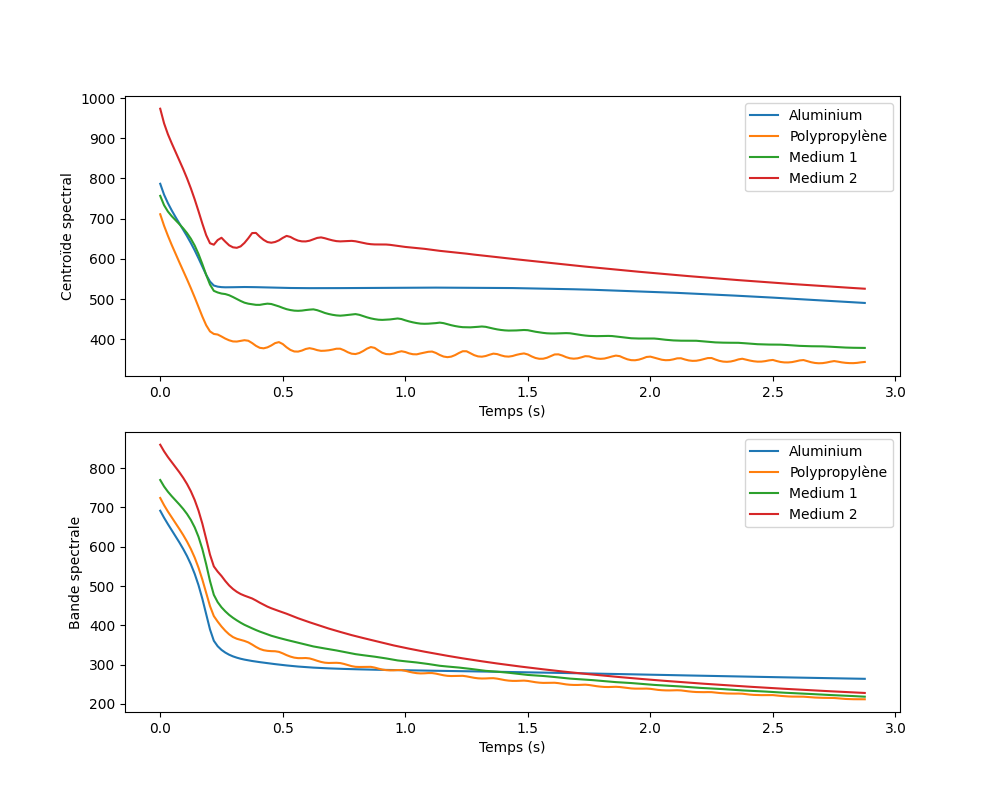

In [15]:
fig,ax = plt.subplots(2,1, figsize=(10,8))
#fig.suptitle("Comparaison de l'évolution de différents descripteurs\n entre les données synthéthiques et expérimentales pour la table Aluminium")
numero = 5
ax[0].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_centroid'][:,numero][debut:fin], label = 'Aluminium')
ax[0].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/plexi/']['spectral_centroid'][:,numero][debut:fin], label = 'Polypropylène')
ax[0].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/medium_1/']['spectral_centroid'][:,numero][debut:fin], label = 'Medium 1')
ax[0].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/medium_2/']['spectral_centroid'][:,numero][debut:fin], label = 'Medium 2')
ax[0].set_xlabel('Temps (s)')
ax[0].set_ylabel('Centroïde spectral')
#ax[0,0].set_title('Centroïde spectral')

ax[1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Aluminium')
ax[1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/plexi/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Polypropylène')
ax[1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/medium_1/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Medium 1')
ax[1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/medium_2/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Medium 2')
ax[1].set_xlabel('Temps (s)')
ax[1].set_ylabel('Bande spectrale')
#ax[1,0].set_title('Pente spectrale')
'''
ax[0,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Aluminium')
ax[0,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/plexi/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Polypropylène')
ax[0,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/medium_1/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Medium 1')
ax[0,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/medium_2/']['spectral_bandwidth'][:,numero][debut:fin], label = 'Medium 2')
ax[0,1].set_xlabel('Temps (s)')
ax[0,1].set_ylabel('Bande spectrale')
#ax[0,1].set_title('Bande spectrale')

ax[1,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/metal/']['spectral_contrast'][:,numero][debut:fin], label = 'Aluminium')
ax[1,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/plexi/']['spectral_contrast'][:,numero][debut:fin], label = 'Polypropylène')
ax[1,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/medium_1/']['spectral_contrast'][:,numero][debut:fin], label = 'Medium 1')
ax[1,1].plot(t_synt[debut:fin],dict_class['../../Mesures/test_vico8/medium_2/']['spectral_contrast'][:,numero][debut:fin], label = 'Medium 2')
ax[1,1].set_xlabel('Temps (s)')
ax[1,1].set_ylabel('Contraste spectral')
'''
ax[0].legend()
ax[1].legend()
'''
ax[1,0].legend()
ax[1,1].legend()
'''

plt.savefig('C:/Users/Ulysse/Desktop/ATIAM/PAM/descripteurs_expressivite.pdf')